# Une exploration visuelle de l'algorithme du Simplexe en 3D avec Python

Dans ce notebook (utilisant Python 3), je souhaite montrer des animations de l'[algorithme du Simplexe](https://fr.wikipedia.org/wiki/Algorithme_du_simplexe), un peu comme dans la [vidéo suivante](https://www.youtube.com/watch?v=W_U8ozVsh8s) :

<iframe width="500" height="250" src="https://www.youtube.com/embed/W_U8ozVsh8s" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

J'aimerai bien écrire un petit morceau de code Python qui fait les étapes suivantes :

- on lui donne le programme linéaire à résoudre (éventuellement sous forme acceptée par [lp_solve](http://web.mit.edu/lpsolve/doc/)) ;
- il résoud le problème avec [`scipy.optimize.linprog(method="simplex")`](https://docs.scipy.org/doc/scipy/reference/optimize.linprog-simplex.html), et s'arrête s'il n'y a pas de solution trouvée par le simplexe ;
- puis utilise le `callback` de cette fonction pour afficher des équations en LaTeX représentant l'évolution du système et des variables de la base et hors base ;
- j'aimerai bien avoir une animation étape par étape, avec un simple "slider" avec [le widget `interact`](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) ;
- bonus : afficher un graphique 3D, avec TikZ ?

Ce document ne sera pas :

- une implémentation maison de l'algorithme du simplexe : c'est trop long et je n'ai pas le temps en ce moment ;
- des explications sur l'algorithme du simplexe : pour cela regardez les notes de cours de [ALGO2](http://people.irisa.fr/Francois.Schwarzentruber/algo2/), et la page Wikipédia sur l'[algorithme du Simplexe](https://fr.wikipedia.org/wiki/Algorithme_du_simplexe) ;
- probablement capable de se faire exporter proprement en HTML statique ;
- et pas non plus capable de se faire exporter proprement en PDF.

## A propros
- Auteur : [Lilian Besson](https://perso.crans.org/besson/)
- License : [MIT](https://lbesson.mit-license.org/)
- Date : 09/02/2021
- Cours : [ALGO2](http://people.irisa.fr/Francois.Schwarzentruber/algo2/) @ [ENS Rennes](http://www.dit.ens-rennes.fr/)

## Vidéo d'explication

Regardez [cette vidéo](https://www.youtube.com/watch?v=W_U8ozVsh8s).

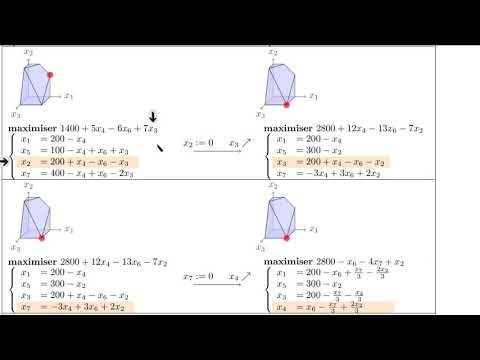

In [2]:
from IPython.display import YouTubeVideo
# https://www.youtube.com/watch?v=W_U8ozVsh8s
YouTubeVideo("W_U8ozVsh8s", width=944, height=531)

---
## Dépendances

On a sûrement besoin de Numpy et Matplotlib :

In [3]:
import numpy as np
import matplotlib.pyplot as plt

On a besoin de la fonction [`scipy.optimize.linprog(method="simplex")`](https://docs.scipy.org/doc/scipy/reference/optimize.linprog-simplex.html) du module [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) :

In [4]:
from scipy.optimize import linprog

On a aussi besoin de la fonction `IPython.display.Latex` pour facilement afficher du code LaTeX généré depuis nos cellules Python :

In [5]:
from IPython.display import Latex, display

Par exemple :

In [6]:
def display_cos_power(power=1):
    return display(Latex(fr"$$\cos(x)^{power} = 0$$"))

for power in range(1, 5):
    display_cos_power(power)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

On va avoir besoin des widgets IPywidgets, plus tard :

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [8]:
interactive(display_cos_power,
   power=(1, 10, 1)
)

interactive(children=(IntSlider(value=1, description='power', max=10, min=1), Output()), _dom_classes=('widget…

Et enfin, de l'extension [itikz](https://github.com/jbn/itikz)

In [9]:
%load_ext itikz

## Première expérience

Déjà, je vais écrire le problème étudié comme un dictionnaire, que l'on pourra passer à [`scipy.optimize.linprog(method="simplex")`](https://docs.scipy.org/doc/scipy/reference/optimize.linprog-simplex.html) :

In [10]:
# Objective Function: 50x_1 + 80x_2
# Constraint 1: 5x_1 + 2x_2 <= 20
# Constraint 2: -10x_1 + -12x_2 <= -90


problem1 = {
    # Cost function: 50x_1 + 80x_2
    "cost": [50, 80],
    # Coefficients for inequalities
    "A_ub": [[5, 2], [-10, -12]],
    # Constraints for inequalities: 20 and -90
    "b_ub": [20, -90],
    # Bounds on x, 0 <= x_i <= +oo by default
    "bounds": (0, None),
}

In [11]:
# Objective Function: maximize x_1 + 6*x_2 + 13*x_3
# => so cost will be opposite
# Constraint 1: x1 <= 200
# Constraint 2: x2 <= 300
# Constraint 3: x1+x2+x3 <= 400
# Constraint 2: x2+3x3 <= 600

problem2 = {
    # Cost function: minimize -1*x_1 + -6*x_2 + -13*x_3
    "cost": [-1, -6, -13],
    # Coefficients for inequalities
    "A_ub": [
        [1, 0, 0],
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 3],
    ],
    # Constraints for inequalities:
    "b_ub": [200, 300, 400, 600],
    # Bounds on x, 0 <= x_i <= +oo by default
    "bounds": (0, None),
}

Puis une petite fonction qui s'occupe de prendre ce dictionnaire et le donner à [`scipy.optimize.linprog(method="simplex")`](https://docs.scipy.org/doc/scipy/reference/optimize.linprog-simplex.html) :

In [12]:
def linprog_wrapper(problem, **kwargs):
    result = linprog(
        problem["cost"],
        A_ub=problem["A_ub"],
        b_ub=problem["b_ub"],
        bounds=problem["bounds"],
        method="simplex",
        **kwargs
    )
    return result

On va déjà vérifier que l'on peut résoudre ces deux exemples de problème de programmation linéaire :

In [13]:
linprog_wrapper(problem1)

     con: array([], dtype=float64)
     fun: 575.0
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([0., 0.])
  status: 0
 success: True
       x: array([1.5 , 6.25])

In [14]:
linprog_wrapper(problem2)

     con: array([], dtype=float64)
     fun: -3100.0
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([2.00000000e+02, 5.68434189e-14, 0.00000000e+00, 0.00000000e+00])
  status: 0
 success: True
       x: array([  0., 300., 100.])

C'est bien la solution $x^* = [0, 300, 100]$, avec un objectif valant $+3100$, qui était trouvée dans la vidéo !

Et si on ajoute un `callback` ?

In [15]:
def round(np_array):
    res = np.array(np.round(np_array), dtype=int)
    if res.size > 1:
        return list(res)
    else:
        return res

In [16]:
def dummy_callback(r):
    print(f"\n- Itération #{r['nit']}, phase {r['phase']} :")
    fun = round(r['fun'])
    print(f"    Valeur objectif    = {fun}")
    slack = round(r['slack'])
    print(f"    Variables d'écart  = {slack}")
    x = round(r['x'])
    print(f"    Variables objectif = {x}")
    # print(r)


In [17]:
linprog_wrapper(problem2, callback=dummy_callback)


- Itération #0, phase 1 :
    Valeur objectif    = 0
    Variables d'écart  = [200, 300, 400, 600]
    Variables objectif = [0, 0, 0]

- Itération #1, phase 1 :
    Valeur objectif    = -2600
    Variables d'écart  = [200, 300, 200, 0]
    Variables objectif = [0, 0, 200]

- Itération #2, phase 1 :
    Valeur objectif    = -2800
    Variables d'écart  = [0, 300, 0, 0]
    Variables objectif = [200, 0, 200]

- Itération #3, phase 1 :
    Valeur objectif    = -2800
    Variables d'écart  = [0, 300, 0, 0]
    Variables objectif = [200, 0, 200]

- Itération #4, phase 1 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]

- Itération #5, phase 1 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]

- Itération #5, phase 2 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]


     con: array([], dtype=float64)
     fun: -3100.0
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([2.00000000e+02, 5.68434189e-14, 0.00000000e+00, 0.00000000e+00])
  status: 0
 success: True
       x: array([  0., 300., 100.])

## Afficher un système d'équation en LaTeX

In [27]:
step_by_step_results = []
step_by_step_nitphase = []

def print_and_store_callback(r):
    global step_by_step_results, step_by_step_nitphase

    nit, phase = r['nit'], r['phase']
    print(f"\n- Itération #{nit}, phase {phase} :")
    fun = round(r['fun'])
    print(f"    Valeur objectif    = {fun}")
    slack = round(r['slack'])
    print(f"    Variables d'écart  = {slack}")
    x = round(r['x'])
    print(f"    Variables objectif = {x}")

    if (nit, phase) not in step_by_step_nitphase:
        step_by_step_results.append(r)
        step_by_step_nitphase.append((nit, phase))

In [28]:
step_by_step_results = []

result_final = linprog_wrapper(problem2, callback=print_and_store_callback)
print(result_final)

step_by_step_results.append(result_final)


- Itération #0, phase 1 :
    Valeur objectif    = 0
    Variables d'écart  = [200, 300, 400, 600]
    Variables objectif = [0, 0, 0]

- Itération #1, phase 1 :
    Valeur objectif    = -2600
    Variables d'écart  = [200, 300, 200, 0]
    Variables objectif = [0, 0, 200]

- Itération #2, phase 1 :
    Valeur objectif    = -2800
    Variables d'écart  = [0, 300, 0, 0]
    Variables objectif = [200, 0, 200]

- Itération #3, phase 1 :
    Valeur objectif    = -2800
    Variables d'écart  = [0, 300, 0, 0]
    Variables objectif = [200, 0, 200]

- Itération #4, phase 1 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]

- Itération #5, phase 1 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]

- Itération #5, phase 2 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]
     con: array([], dtype=float64)
     f

On a donc récupéré un certain nombre d'objets résultat intermédiaire d'optimisation :

In [29]:
len(step_by_step_results)

8

En fait, je me rends compte que les informations données par ces `results` successifs ne sont pas suffisantes pour afficher des équations comme dans la vidéo.

## Implémentation maison du Simplexe en dimension 3

## Exemples

## Suite des expérimentations

On va écrire une fonction qui produit du code LaTeX représentant ce système d'optimisation, au cours des réécritures qu'il subit :

In [ ]:
def equation_latex_from_step(result):
    return r"""
    \text{Maximiser}""" + cout + r"""\\
    \begin{cases}
    
    \end{cases}
    """

TODO: terminer ça !

## Ajouter de l'interactivité

In [ ]:
def interactive_latex_exploration(problem):
    problem_solved = make_show_latex(problem1)
    if problem_solved.status != 0:
        print("Error: problem was not solve correctly, stopping this...")
    interactive_function = make_show_latex(problem1)
    max_step = problem_solved.nitint

    return interact(, step=(0, max_step))

Allez on essaie :

In [23]:
interactive_latex_exploration(problem)

NameError: name 'interactive_latex_exploration' is not defined

## Ajouter des figures TikZ

Avec [itikz](https://github.com/jbn/itikz)

In [135]:
%load_ext itikz

The itikz extension is already loaded. To reload it, use:
  %reload_ext itikz


Par exemple on peut afficher un premier exemple, avant de chercher à les faire bouger :

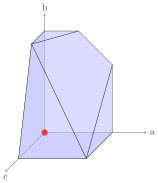

In [138]:
%%itikz --temp-dir --file-prefix simplex-example-
\documentclass[tikz]{standalone}
\usepackage{amsfonts}
\begin{document}
% from http://people.irisa.fr/Francois.Schwarzentruber/algo2/ notes
\usetikzlibrary{arrows,patterns,topaths,shadows,shapes,positioning}
\begin{tikzpicture}[scale=0.012, opacity=0.7]
\tikzstyle{point} = [fill=red, circle, inner sep=0.8mm];
\draw[->] (0, 0, 0) -- (300, 0, 0) node[right] {a};
\draw[->] (0, 0, 0) -- (0, 350, 0) node[above] {b};
\draw[->] (0, 0, 0) -- (0, 0, 300) node[below] {c};

\coordinate (O) at (0,0,0);
\coordinate (D) at (200,0,0);
\coordinate (E) at (200, 0, 200);
\coordinate (F) at (0, 0, 200);
\coordinate (G) at (0, 300,0);
\coordinate (C) at (200,200,0);
\coordinate (A) at (100,300, 0);
\coordinate (B) at (0,300, 100);
\draw[fill=blue!20] (O) -- (D) -- (E) -- (F) -- (O) -- cycle;
\draw[fill=blue!20] (D) -- (C) -- (E) -- cycle;
\draw[fill=blue!20] (G) -- (B) -- (F) -- (O) -- cycle;
\draw[fill=blue!20] (B) -- (A) -- (C) --(E) -- cycle;
\draw[fill=blue!20] (B) -- (F) -- (E) -- cycle;
\draw[fill=blue!20] (B) -- (A) -- (G) -- cycle;
\node[point] at (0,0,0) {};  % TODO make this argument of function
\end{tikzpicture}
\end{document}

Maintenant on peut chercher à contrôler la position du point objectif actuel :
a,b,c sera $x_1, x_2, x_3$.

In [173]:
simplex_example_str = ""

def default_cost(a, b, c):
    """1*{a} + 6*{b} + 13*{c}"""
    return 1*a + 6*b + 13*c

def show_tikz_figure_with_point(a=0, b=0, c=0, cost=default_cost):
    # TODO generate nice LaTeX equations
    if cost:
        current_cost = cost(a, b, c)
        cost_doc = cost.__doc__.format(a=a, b=b, c=c)
        print(f"Coût = {cost_doc} = {current_cost}")
    equation_latex = f"""\
Cout $f(a,b,c) = {cost_doc} = {current_cost}$.\
"""
    display(Latex(equation_latex))
    # now tikz
    global simplex_example_str
    simplex_example_str = r"""
\documentclass[tikz]{standalone}
\begin{document}
% from http://people.irisa.fr/Francois.Schwarzentruber/algo2/ notes
\usetikzlibrary{arrows,patterns,topaths,shadows,shapes,positioning}
\begin{tikzpicture}[scale=0.016, opacity=0.7]
\tikzstyle{point} = [fill=red, circle, inner sep=0.8mm];
\draw[->] (0, 0, 0) -- (300, 0, 0) node[right] {a};
\draw[->] (0, 0, 0) -- (0, 350, 0) node[above] {b};
\draw[->] (0, 0, 0) -- (0, 0, 300) node[below] {c};

\coordinate (O) at (0,0,0);
\coordinate (D) at (200,0,0);
\coordinate (E) at (200, 0, 200);
\coordinate (F) at (0, 0, 200);
\coordinate (G) at (0, 300,0);
\coordinate (C) at (200,200,0);
\coordinate (A) at (100,300, 0);
\coordinate (B) at (0,300, 100);
\draw[fill=blue!20] (O) -- (D) -- (E) -- (F) -- (O) -- cycle;
\draw[fill=blue!20] (D) -- (C) -- (E) -- cycle;
\draw[fill=blue!20] (G) -- (B) -- (F) -- (O) -- cycle;
\draw[fill=blue!20] (B) -- (A) -- (C) --(E) -- cycle;
\draw[fill=blue!20] (B) -- (F) -- (E) -- cycle;
\draw[fill=blue!20] (B) -- (A) -- (G) -- cycle;
\node[point] at (""" +  f"{a}, {b}, {c}" + """) {};
\end{tikzpicture}
\end{document}
"""
    #print(simplex_example_str)
    # TODO: run this from this function?
    #%itikz --temp-dir --file-prefix simplex-example- simplex_example_str
    return get_ipython().run_line_magic(
        "itikz", "--temp-dir --file-prefix simplex-example- simplex_example_str"
    )

Coût = 1*0 + 6*0 + 13*0 = 0


<IPython.core.display.Latex object>

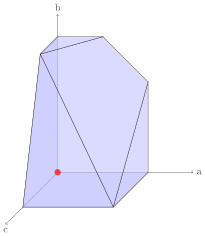

In [175]:
show_tikz_figure_with_point(0, 0, 0)

Et en rendant cela interactif, on peut jouer avec ça.

<span style="color:red;">ATTENTION : même si les widgets sont présents dans une version statique de cette page (au format HTML ou sur [nbviewer.jupyter.org](https://nbviewer.jupyter.org/), la figure ne peut pas être modifée. Si vous souhaitez expérimenter de votre côté, il faut exécuter le notebook localement depuis votre propre Jupyter, ou avec MyBinder en cliquant sur un des boutons suivants :</span>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Naereen/notebooks/master?filepath=Une_exploration_visuelle_de_l_algorithme_du_Simplexe_en_3D_avec_Python.ipynb)
[![MyBinder v2](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Naereen/notebooks/master)

In [177]:
interact(
    show_tikz_figure_with_point,
    a = (-100, 300, 10),
    b = (-100, 300, 10),
    c = (-100, 300, 10),
    cost = fixed(default_cost)
)

interactive(children=(IntSlider(value=0, description='a', max=300, min=-100, step=10), IntSlider(value=0, desc…

<function __main__.show_tikz_figure_with_point(a=0, b=0, c=0, cost=<function default_cost at 0x7efd69c9dbf8>)>

In [151]:
linprog_wrapper(problem2, callback=dummy_callback)


- Itération #0, phase 1 :
    Valeur objectif    = 0
    Variables d'écart  = [200, 300, 400, 600]
    Variables objectif = [0, 0, 0]

- Itération #1, phase 1 :
    Valeur objectif    = -2600
    Variables d'écart  = [200, 300, 200, 0]
    Variables objectif = [0, 0, 200]

- Itération #2, phase 1 :
    Valeur objectif    = -2800
    Variables d'écart  = [0, 300, 0, 0]
    Variables objectif = [200, 0, 200]

- Itération #3, phase 1 :
    Valeur objectif    = -2800
    Variables d'écart  = [0, 300, 0, 0]
    Variables objectif = [200, 0, 200]

- Itération #4, phase 1 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]

- Itération #5, phase 1 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]

- Itération #5, phase 2 :
    Valeur objectif    = -3100
    Variables d'écart  = [200, 0, 0, 0]
    Variables objectif = [0, 300, 100]


     con: array([], dtype=float64)
     fun: -3100.0
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([2.00000000e+02, 5.68434189e-14, 0.00000000e+00, 0.00000000e+00])
  status: 0
 success: True
       x: array([  0., 300., 100.])

## Conclusion

C'était amusant.

> Voir [d'autres notebooks](https://github.com/Naereen/notebooks/).